# RL Trading
## Explore the posibility of using forcasted prices as features in the environment
### TODO : input data need to be changed

In [2]:
import warnings
warnings.filterwarnings('ignore')

###  Overview

In this notebook we'll explore how to apply Recurrent Neural Networks (RNNs) in financial time series analysis, comparing to well-known techniques in Financial Econometrics. We can think on RNNs as non-linear time series models that generalize classical linear models such as AR(p), MA(q), ARIMA(p, d, q) that you have probably studied in classic statistics courses. They provide a powerful approach for prediction in financial time series and generalize to non-stationary data.

The notebook provides an example of how Keras can be used to train a RNNs for (real) time series prediction. The example dataset is for predicting from noisy, non-stationary data.

A few things are important:

- We shall use autoregressive models to identify the sequence length needed in the RNN. We need to specify a sequence length to feed the RNN, how many time steps we need to select is selected by studying the partial autocorrelation.

- Plain RNNs are not suited to non-stationary time series modeling. We can use a GRU or LSTM to model non-stationary data, since these models exhibit dynamic auto-correlation structure.

- Unlike classical time series methods, e.g. ARIMA, there are no parametric assumptions on the distribution of the errors.

- The data is snapshots of the USD value of Coinbase every minute over 2018.

- We choose to build a model which provides strong predictive power, at the expense of reduced explanatory power.

- Our choice to use an RNN is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.

- Our primary concern is assessing the extent to which the model is over-fitting, by comparing the in- and out-of-sample MSEs.

- In (financial) time series analysis we identify in- and out-of-sample with train and test sets.

- It is important to ensure that `shuffle=False` in the fit function, otherwise the ordering of sequences is not preserved. This is especially important for methods which have memory beyond the current sequence (i.e. all methods except RNNs).

Let's load needed libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras.initializers
from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
%matplotlib inline

In [5]:
# check tensorflow detects my GPU:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

### Data

- The example dataset $X$ is a chronologically ordered time series. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- Each observation in $X$ has one variable (a.k.a. univariate time series).

Loading the data into a Pandas Dataframe, then viewing the first ten observations:

In [6]:
df = pd.read_csv('data/coinbase.csv', index_col=1)
df.index = pd.to_datetime(df.index, infer_datetime_format=True)

In [7]:
df.head(5)

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931


The dataset contains missing values; these correspond to timestamps without actual transactions; in order to prevent this causing errors, we replace these with adjacent values from the time series.

In [8]:
nof_missing_values = sum(np.isnan(df['USD']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [9]:
df = df.fillna(method="backfill")

nof_missing_values = sum(np.isnan(df['USD']))

print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


# RNN Regression
- We consider a univariate prediction problem where the time series is given by 'USD' in the data frame
- For each input sequence we predict the value **4 time-steps into the future**. 
- Therefore, we have a simple predictions from a previous known prices (**many-to-one RNN structure**)
- That prediction is the BTC(USD) price four minutes ahead in the future which could be used for trading purposes in a trading strategy.
- We need to decide how many features (timesteps) to use for feeding the network.

In [10]:
use_features = ['USD'] # continuous input
target = ['USD'] # continuous output
n_steps_ahead = 4 # forecasting horizon (how many steps ahead we are looking)

### Recurrent Neural Networks as non-linear AR(p) models

To decide how many features to use we will use the time series PACF, so let's review first some basic econometrics concepts.

**Stochastic Process**

A stochastic process is a sequence of random variables, indexed by continuous time: $\{Y_t\}_{t=-\infty}^{\infty}$.

**Time Series**

A time series is a sequence of observations of a stochastic process at discrete times over a specific interval: $\{y_t\}_{t=1}^{n}$.

**Autocovariance**

The $j$th autocovariance of a time series is the covariance between the series at $t$ and the $j$th lagged value,

$$
\gamma_{jt} :=  E[(y_t - \mu_t )(y_{t-j} - \mu_{t-j})],
$$
where $\mu_t := E[y_t]$.

**Covariance (Weak) Stationarity**

A time series is weak (or wide-sense) covariance stationary if it has __time constant__ mean and autocovariances of all orders:

\begin{align}
\mu_t &= \mu\, , \forall t\\
\gamma_{jt} &= \gamma_j\, , \forall t\, .
\end{align}

**Autocorrelation**

The $j$th autocorrelation, $\tau_j$ is just the $j$th autocovariance divided by the variance:

$$
\tau_j = \frac{\gamma_j}{\gamma_0}\, .
$$

**White Noise**

White noise, $\epsilon_t$, is i.i.d. error which satisfies all three conditions:

- $E[ \epsilon_t ] = 0$, $\forall\, t$;
- $V[ \epsilon_t] = \sigma^2$, $\forall\, t$; and
- $\epsilon_t$ and $\epsilon_s$ are independent, $t\neq s$, $\forall\, t, s$.

**Autoregressive Process AR(p)**

Autoregressive models are parametric time series models describing $y_t$ as a linear combination of $p$ past observations and white noise.

$$
y_t = \mu + \sum_{i=1}^{p} \phi_i y_{t-i} + \epsilon_t\, ,
$$

where $\epsilon_t$ is independent of $\{y_{t−1}\}_{i=1}$. We refer to $\mu$ as the drift term. $p$ is referred to as the order of the model.

**Recurrent neural networks as time series models**

RNNs are non-linear time series models that can be used to generalize classical linear time series models such as AR(p). Assume that we "reformulate" our time series as an input-output pair $D := \{x_t,y_t\}_{t=1}^{N}$ of autocorrelated observations of $X$ and $Y$ at times $t = 1,\ldots, N$, then the fundamental prediction problem can be expressed as a sequence prediction problem: construct a non-linear times series predictor, $\hat{y}_{t+h}$ of a response $y_{t+h}$ using a high-dimensional input matrix of $T$ length sub-sequences $X_t$ as:

$$
\hat{y}_{t+h} = f(X_t)\hspace{0.25cm} \text{where}\hspace{0.25cm} X_t :=seq_{T, t}(X)= (x_{t-T+1},\ldots, x_t)\, ,
$$

where $x_{t−j}$ is a $j$th lagged observation of $x_t$. Sequence learning is just a composition of a non-linear map and a vectorization of the lagged input variables.


### Stationarity

It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostic tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

The [**Augmented Dickey-Fuller**](https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test) test helps to diagnosis stationarity. A time series ia stationary if there are no unit roots.

The null hypothesis of the Augmented Dickey-Fuller test is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the memory requirements of the test. We use the first 200,000 samples to test for stationarity. While the test statistic is sensitive to the data size, the ADF test is always accepted at the 99\% level.

In [11]:
from statsmodels.tsa.stattools import adfuller, pacf

In [12]:
sample = df['USD'][:200000]
adf, p, usedlag, nobs, cvs, aic = adfuller(sample)

In [13]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.094557163375799
p-value: 0.24670881839393738,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


Here we accept the null as the p-value is larger than 0.01, thus we can not reject the test at the 99% confidence level. This suggests that the time series is **non-stationary**.

#### Autoregressive Model Identification: The partial auto-correlation

Once we have identified that our time series is non-stationary, it is important to identify what is the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation). Autocorrelation can be gauged by the number of lags the time series is correlated with past copies of itself. Moreover, it is important to determine the number of lags, i.e., the **sequence length**, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming. 

By definition, a [partial auto-correlation (PACF)](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$

where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the [stattools](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html) package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [14]:
pacf = pacf(df[use_features], nlags=30)

Since $\Phi^{-1}(0.99) \simeq 2.58$:

In [15]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [16]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of 4 lags appears satisfactory, although more may be needed. Unlike autoregressive models, the advantage of using fewer parameters is purely computational as adding more lags does not increase the number of parameters, only the size of the tensorial representation of the sequence data in TensorFlow. 

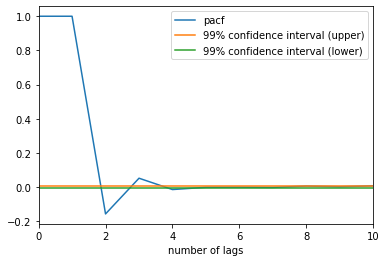

In [17]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.xlim(0,10)
plt.legend();

### Splitting the time series into training and testing sets

We split the training and test set by using the first 80% of the time series for the train set and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [18]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]


### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [19]:
mu = float(df_train.mean())
sigma = float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

### Data formatting for RNNs

TensorFlow uses tensors to represent data. To perform sequence learning, the time series of variables must be transformed to a series of over-lapping sub-sequences. We need to create a regular $X$ and $y$ dataset.

For example, consider a univariate time series of increasing integers.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10 (in our particular case will be 4), for example, we move the window forward by one observation at a time and construct new sequences:

| Feature | Prediction |
| :--- | :--- |
| [1 2 3 4 5 6 7 8 9]      | [10] |
| [2 3 4 5 6 7 8 9 10]     | [11] |
| [3 4 5 6 7 8 9 10 11]    | [12] |
| [4 5 6 7 8 9 10 11 12]   | [13] |
| [5 6 7 8 9 10 11 12 13]  | [14] |
| [6 7 8 9 10 11 12 13 14] | [15] |


Let's define the following function for reshaping our time series data into one-step ahead times series prediction format. The function goes along the time series and creates tabular data out of it.

In [20]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    # create a list of 4 dfs with a shift of 4 timestamps:
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    
    # dstack function creates arrays of 4 consecutive time series values
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    
    # swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    
    return lag_array

We shall first transform the training input and output data.

In [21]:
n_steps, n_steps_ahead


(4, 4)

In [22]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

Let's print the shapes of each tensor:

- The first digit is the number of observations. For feature arrays, the second digit is the sequence length (i.e. the number of lags in the model) and the final digit is the dimension of each element in the sequence or output vector respectively. In this case, the example performs univariate time series analysis and so the dimension of the input and output is 1.

- We have a tensor with 361337 sequences of length 4, each of them with a numeric target (just a number) indicating the value of the time series four steps ahead into the future.


In [23]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(361337, 4, 1), (361337, 1), (90330, 4, 1), (90330, 1)]


We have just created our $X$ and $y$ tensors.

### Model Specification

We define here different [recurrent models](https://keras.io/api/layers/recurrent_layers/).

In [24]:
from tensorflow.keras.initializers import glorot_uniform, orthogonal


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(SimpleRNN(n_units, 
                        activation='tanh', 
                        kernel_initializer=glorot_uniform(seed), 
                        bias_initializer=glorot_uniform(seed), 
                        recurrent_initializer=orthogonal(seed), 
                        kernel_regularizer=l1(l1_reg), 
                        input_shape=(x_train.shape[1], x_train.shape[-1]), 
                        unroll=True, stateful=False))  
    model.add(Dense(1, 
                    kernel_initializer=glorot_uniform(seed), 
                    bias_initializer=glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(GRU(n_units, 
                  activation='tanh', 
                  kernel_initializer=glorot_uniform(seed), 
                  bias_initializer=glorot_uniform(seed), 
                  recurrent_initializer=orthogonal(seed), 
                  kernel_regularizer=l1(l1_reg), 
                  input_shape=(x_train.shape[1], x_train.shape[-1]), 
                  unroll=True))
    model.add(Dense(1, 
                    kernel_initializer=glorot_uniform(seed), 
                    bias_initializer=glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
    model = Sequential()
    model.add(LSTM(n_units, 
                   activation='tanh', 
                   kernel_initializer=glorot_uniform(seed), 
                   bias_initializer=glorot_uniform(seed), 
                   recurrent_initializer=orthogonal(seed), 
                   kernel_regularizer=l1(l1_reg), 
                   input_shape=(x_train.shape[1], x_train.shape[-1]), 
                   unroll=True))
    model.add(Dense(1, 
                    kernel_initializer=glorot_uniform(seed), 
                    bias_initializer=glorot_uniform(seed), 
                    kernel_regularizer=l1(l1_reg)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [25]:
max_epochs = 1000
batch_size = 1000

Use a batch size of 1000 as the dataset is reasonably large and the training time would be too long otherwise. 20 epochs have been used here, but a better approach would be to use a stopping criteria through a call back. 

In [26]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [27]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [28]:
do_training = True # Set to True if you wish to train your own models

# Train model without model selection through cv

Ideally a grid search (or other HPO method) can be performed to find the best the parameters `n_units` and `l1_reg`. This HPO takes so much time (for normal GPUs), then the values from the initialisation of `params` above are used.

The following cell will train the three models sequentially, storing the fitted model in `params['rnn|gru|lstm']['model']`, this later is save into disk.

In [31]:
%%time

# this takes about 1h 23 min with NVIDIA GeForce GTX 1650 GPU
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0096
Epoch 2/1000
362/362 [==============================] - 1s 1ms/step - loss: 0.0136
Epoch 3/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0149
Epoch 4/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 5/1000
362/362 [==============================] - 1s 1ms/step - loss: 0.0136
Epoch 6/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0140
Epoch 7/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 8/1000
362/362 [==============================] - 1s 1ms/step - loss: 0.0125
Epoch 9/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0106
Epoch 10/1000
362/362 [==============================] - 0s 1ms/step - loss: 0.0120
Epoch 11/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0107
Epoch 12/1000
362/362 [==============================] - 1s 2ms/st

362/362 [==============================] - 1s 2ms/step - loss: 6.6098e-04
Epoch 194/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0011
Epoch 195/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 196/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 197/1000
362/362 [==============================] - 1s 2ms/step - loss: 9.5671e-04
Epoch 198/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 199/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 200/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 201/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 202/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0015
Epoch 203/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 204/1000
362/362 [==============================] - 1s 3ms/step - 

362/362 [==============================] - 1s 2ms/step - loss: 6.5547e-04
Epoch 383/1000
362/362 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 384/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 385/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 386/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 387/1000
362/362 [==============================] - 1s 2ms/step - loss: 8.2364e-04
Epoch 388/1000
362/362 [==============================] - 1s 2ms/step - loss: 7.2847e-04
Epoch 389/1000
362/362 [==============================] - 1s 2ms/step - loss: 9.9918e-04
Epoch 390/1000
362/362 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 391/1000
362/362 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 392/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 393/1000
362/362 [==============================] - 1s 2ms

362/362 [==============================] - 1s 1ms/step - loss: 9.9622e-04
Epoch 570/1000
362/362 [==============================] - 1s 1ms/step - loss: 5.2210e-04
Epoch 571/1000
362/362 [==============================] - 0s 1ms/step - loss: 3.3736e-04
Epoch 572/1000
362/362 [==============================] - 0s 1ms/step - loss: 5.1494e-04
Epoch 573/1000
362/362 [==============================] - 0s 1ms/step - loss: 7.3376e-04
Epoch 574/1000
362/362 [==============================] - 1s 1ms/step - loss: 5.4017e-04
Epoch 575/1000
362/362 [==============================] - 0s 1ms/step - loss: 8.9387e-04
Epoch 576/1000
362/362 [==============================] - 0s 1ms/step - loss: 3.0291e-04
Epoch 577/1000
362/362 [==============================] - 0s 1ms/step - loss: 4.9097e-04
Epoch 578/1000
362/362 [==============================] - 0s 1ms/step - loss: 9.3916e-04
Epoch 579/1000
362/362 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 580/1000
362/362 [================

362/362 [==============================] - 1s 3ms/step - loss: 9.7662e-04
Epoch 132/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 133/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 134/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 135/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0010
Epoch 136/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 137/1000
362/362 [==============================] - 1s 3ms/step - loss: 9.9739e-04
Epoch 138/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 139/1000
362/362 [==============================] - 1s 4ms/step - loss: 9.4698e-04
Epoch 140/1000
362/362 [==============================] - 2s 5ms/step - loss: 9.5505e-04
Epoch 141/1000
362/362 [==============================] - 2s 5ms/step - loss: 9.1298e-04
Epoch 142/1000
362/362 [==============================] - 2s

362/362 [==============================] - 1s 4ms/step - loss: 5.5284e-04
Epoch 316/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.5260e-04
Epoch 317/1000
362/362 [==============================] - 2s 6ms/step - loss: 5.5067e-04
Epoch 318/1000
362/362 [==============================] - 2s 6ms/step - loss: 5.5043e-04
Epoch 319/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.4902e-04
Epoch 320/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.4885e-04
Epoch 321/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.4758e-04
Epoch 322/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.4715e-04
Epoch 323/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.4560e-04
Epoch 324/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.4491e-04
Epoch 325/1000
362/362 [==============================] - 2s 7ms/step - loss: 5.4317e-04
Epoch 326/1000
362/362 [============

362/362 [==============================] - 1s 4ms/step - loss: 4.2745e-04
Epoch 500/1000
362/362 [==============================] - 2s 6ms/step - loss: 4.2702e-04
Epoch 501/1000
362/362 [==============================] - 1s 4ms/step - loss: 4.2660e-04
Epoch 502/1000
362/362 [==============================] - 1s 4ms/step - loss: 4.2619e-04
Epoch 503/1000
362/362 [==============================] - 1s 4ms/step - loss: 4.2575e-04
Epoch 504/1000
362/362 [==============================] - 2s 4ms/step - loss: 4.2529e-04
Epoch 505/1000
362/362 [==============================] - 1s 4ms/step - loss: 4.2483e-04
Epoch 506/1000
362/362 [==============================] - 2s 4ms/step - loss: 4.2439e-04
Epoch 507/1000
362/362 [==============================] - 2s 4ms/step - loss: 4.2400e-04
Epoch 508/1000
362/362 [==============================] - 1s 3ms/step - loss: 4.2363e-04
Epoch 509/1000
362/362 [==============================] - 2s 6ms/step - loss: 4.2323e-04
Epoch 510/1000
362/362 [============

362/362 [==============================] - 1s 3ms/step - loss: 3.4261e-04
Epoch 684/1000
362/362 [==============================] - 1s 4ms/step - loss: 3.4543e-04
Epoch 685/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.4173e-04
Epoch 686/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.4473e-04
Epoch 687/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.4087e-04
Epoch 688/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.4403e-04
Epoch 689/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.4001e-04
Epoch 690/1000
362/362 [==============================] - 2s 4ms/step - loss: 3.4336e-04
Epoch 691/1000
362/362 [==============================] - 2s 4ms/step - loss: 3.3919e-04
Epoch 692/1000
362/362 [==============================] - 1s 2ms/step - loss: 3.4269e-04
Epoch 693/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.3835e-04
Epoch 694/1000
362/362 [============

362/362 [==============================] - 1s 4ms/step - loss: 2.9620e-04
Epoch 868/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.0709e-04
Epoch 869/1000
362/362 [==============================] - 2s 5ms/step - loss: 2.9591e-04
Epoch 870/1000
362/362 [==============================] - 2s 7ms/step - loss: 3.0685e-04
Epoch 871/1000
362/362 [==============================] - 2s 5ms/step - loss: 2.9561e-04
Epoch 872/1000
362/362 [==============================] - 2s 6ms/step - loss: 3.0660e-04
Epoch 873/1000
362/362 [==============================] - 2s 6ms/step - loss: 2.9532e-04
Epoch 874/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.0636e-04
Epoch 875/1000
362/362 [==============================] - 2s 4ms/step - loss: 2.9504e-04
Epoch 876/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.0612e-04
Epoch 877/1000
362/362 [==============================] - 2s 5ms/step - loss: 2.9474e-04
Epoch 878/1000
362/362 [============

362/362 [==============================] - 2s 5ms/step - loss: 0.0024
Epoch 53/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0024
Epoch 54/1000
362/362 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 55/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0023
Epoch 56/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 57/1000
362/362 [==============================] - 2s 5ms/step - loss: 0.0022
Epoch 58/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 59/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 60/1000
362/362 [==============================] - 2s 4ms/step - loss: 0.0022
Epoch 61/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 62/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 63/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 

362/362 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 150/1000
362/362 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 151/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 152/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 153/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 154/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 155/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 156/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 157/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 158/1000
362/362 [==============================] - 2s 4ms/step - loss: 0.0011
Epoch 159/1000
362/362 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 160/1000
362/362 [==============================] - 1s 4ms/step - loss: 0.

362/362 [==============================] - 2s 4ms/step - loss: 5.8708e-04
Epoch 335/1000
362/362 [==============================] - 2s 4ms/step - loss: 5.8514e-04
Epoch 336/1000
362/362 [==============================] - 1s 3ms/step - loss: 5.8320e-04
Epoch 337/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.8126e-04
Epoch 338/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.7932e-04
Epoch 339/1000
362/362 [==============================] - 2s 5ms/step - loss: 5.7738e-04
Epoch 340/1000
362/362 [==============================] - 1s 4ms/step - loss: 5.7544e-04
Epoch 341/1000
362/362 [==============================] - 1s 3ms/step - loss: 5.7352e-04
Epoch 342/1000
362/362 [==============================] - 1s 4ms/step - loss: 5.7160e-04
Epoch 343/1000
362/362 [==============================] - 1s 2ms/step - loss: 5.6967e-04
Epoch 344/1000
362/362 [==============================] - 1s 2ms/step - loss: 5.6775e-04
Epoch 345/1000
362/362 [============

362/362 [==============================] - 1s 4ms/step - loss: 3.8731e-04
Epoch 519/1000
362/362 [==============================] - 1s 3ms/step - loss: 4.4421e-04
Epoch 520/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.8613e-04
Epoch 521/1000
362/362 [==============================] - 1s 3ms/step - loss: 4.4323e-04
Epoch 522/1000
362/362 [==============================] - 1s 4ms/step - loss: 3.8495e-04
Epoch 523/1000
362/362 [==============================] - 2s 4ms/step - loss: 4.4226e-04
Epoch 524/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.8380e-04
Epoch 525/1000
362/362 [==============================] - 2s 4ms/step - loss: 4.4131e-04
Epoch 526/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.8266e-04
Epoch 527/1000
362/362 [==============================] - 1s 4ms/step - loss: 4.4038e-04
Epoch 528/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.8153e-04
Epoch 529/1000
362/362 [============

362/362 [==============================] - 1s 3ms/step - loss: 3.1650e-04
Epoch 703/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.8316e-04
Epoch 704/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.1599e-04
Epoch 705/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.8266e-04
Epoch 706/1000
362/362 [==============================] - 2s 5ms/step - loss: 3.1550e-04
Epoch 707/1000
362/362 [==============================] - 2s 6ms/step - loss: 3.8214e-04
Epoch 708/1000
362/362 [==============================] - 2s 4ms/step - loss: 3.1501e-04
Epoch 709/1000
362/362 [==============================] - 1s 4ms/step - loss: 3.8163e-04
Epoch 710/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.1451e-04
Epoch 711/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.8112e-04
Epoch 712/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.1402e-04
Epoch 713/1000
362/362 [============

362/362 [==============================] - 1s 3ms/step - loss: 2.8154e-04
Epoch 887/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.3835e-04
Epoch 888/1000
362/362 [==============================] - 1s 4ms/step - loss: 2.8127e-04
Epoch 889/1000
362/362 [==============================] - 1s 4ms/step - loss: 3.3793e-04
Epoch 890/1000
362/362 [==============================] - 2s 5ms/step - loss: 2.8099e-04
Epoch 891/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.3751e-04
Epoch 892/1000
362/362 [==============================] - 1s 3ms/step - loss: 2.8073e-04
Epoch 893/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.3710e-04
Epoch 894/1000
362/362 [==============================] - 1s 4ms/step - loss: 2.8046e-04
Epoch 895/1000
362/362 [==============================] - 1s 3ms/step - loss: 3.3669e-04
Epoch 896/1000
362/362 [==============================] - 1s 3ms/step - loss: 2.8019e-04
Epoch 897/1000
362/362 [============

Save the fitted models:

In [32]:
for key in params.keys():
    params[key]['model'].save('RNNs-Bitcoin-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

### Prediction

We shall now apply the fitted RNN models to the training and test sets, separately. We can then informally assess the extent of over-fitting.

In [33]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
2823/2823 [==============================] - 2s 806us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 401
Trainable params: 401
Non-trainable params: 0
___________________________________________

### Model Performance

Finally assess the performance of the model in and out-of-sample using the MSE. We expect the mean error to be larger on the test set than on the training set. 

In [34]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

# Upper limits for `l` & `u` in the cells below:

training set: 361337
testing set: 90330


In [35]:
print(params.keys())

# Set `compare` in the cells below to a list
# containing any subset of these:

dict_keys(['rnn', 'gru', 'lstm'])


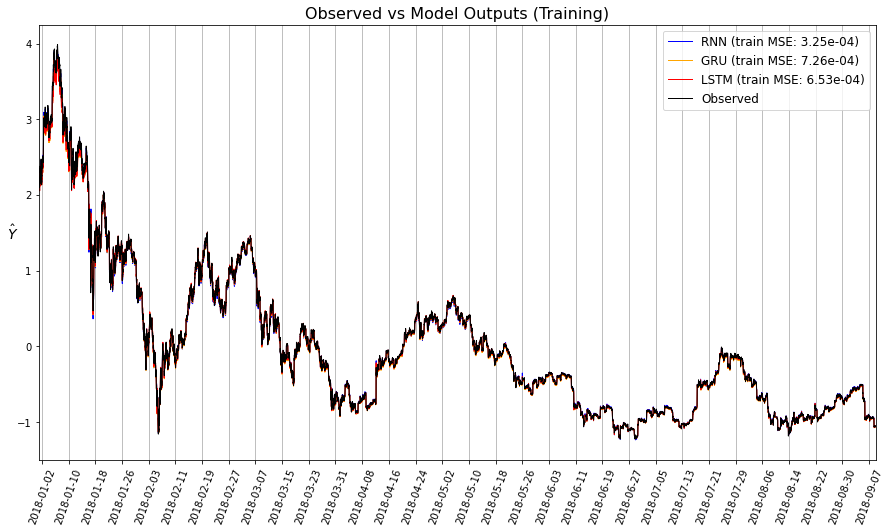

In [36]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn'] or ['rnn', 'lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

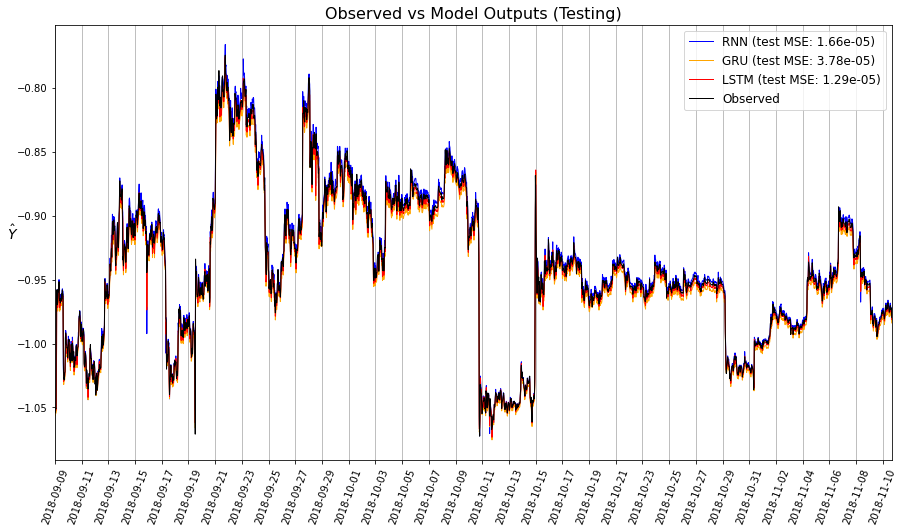

In [37]:
compare = params.keys() # e.g. ['rnn'] or ['rnn', 'lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

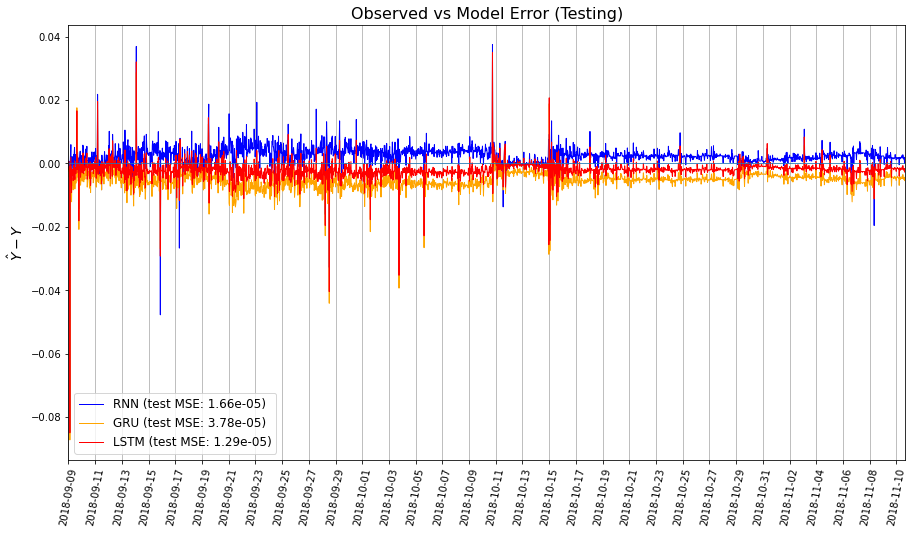

In [38]:
compare = params.keys() # e.g. ['rnn'] or ['rnn', 'lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

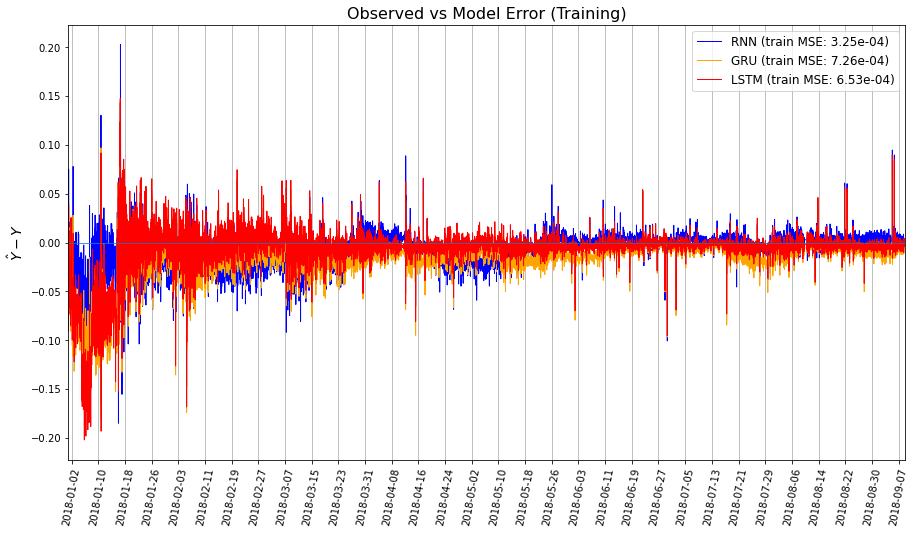

In [39]:
compare = params.keys() # e.g. ['rnn'] or ['rnn', 'lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);